In [1]:
import tensorflow as tf
from tensorflow import keras, data
from tensorflow.keras import layers, models, utils

import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import pandas as pd
from tqdm.notebook import tqdm
import os

2024-03-21 21:20:38.552804: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 21:20:38.552952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 21:20:38.554614: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 21:20:38.565438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 21:20:40.507652: W tensorflow/compiler/tf2

In [2]:
IMG_SIZE=96
BATCH_SIZE=32
LATENT_DIM=256

dataset:

https://www.kaggle.com/datasets/noamsegal/affectnet-training-data/data

In [3]:
dataset_path = 'faces/'

processed = []

# Iterate through images, crop, scale and store them in 'processed' array
for img in tqdm(os.listdir(dataset_path)):
    img = cv2.imread(dataset_path+img) #read image
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           #convert to RGB
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))           #resize
    img = tf.cast(img,'float32')/127.5 - 1              #normalize image to [-1,1]
    processed.append(img)                               #store in array

  0%|          | 0/29042 [00:00<?, ?it/s]

2024-03-21 21:20:42.646388: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 21:20:42.698658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-21 21:20:42.699336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# Create a tensorflow dataset from given data, shuffle images and group them into batches
limit_training = 10000
test = 300

processed = np.array(processed)
np.random.shuffle(processed)

train_dataset = data.Dataset.from_tensor_slices(processed[:limit_training]) \
                .shuffle(1024, reshuffle_each_iteration=True) \
                .batch(BATCH_SIZE)

test_dataset = data.Dataset.from_tensor_slices(processed[limit_training:limit_training + test]).batch(BATCH_SIZE)
print(train_dataset,test_dataset)

2024-03-21 21:21:20.022325: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.


<_BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)> <_BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)>


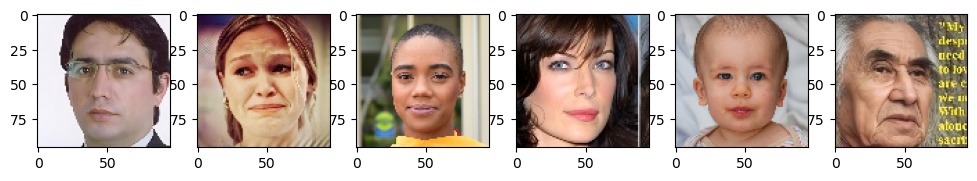

In [5]:
# Take a look at the dataset
imgs = next(iter(test_dataset))
fig = plt.figure(figsize=(12, 8))
rows = 6
for i in range(rows):
    fig.add_subplot(1,rows,i+1)
    plt.imshow((imgs[i]+1)*0.5) #scale images back to [0,1] in order to show them
plt.show()

In [6]:
class Generator(models.Model):
    def __init__(self):
        super().__init__()
        self.model = keras.Sequential([
            keras.Input(shape=(LATENT_DIM,)),
            layers.Dense(6*6*512, use_bias=False),
            layers.Reshape((6, 6, 512)),
            layers.BatchNormalization(),

            # layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', use_bias=False),  # 6 -> 12
            layers.UpSampling2D(),
            layers.SpectralNormalization(layers.Conv2D(512, (3, 3), padding='same', use_bias=False)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            # layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False),  # 12 -> 24
            layers.UpSampling2D(),
            layers.SpectralNormalization(layers.Conv2D(256, (3, 3), padding='same', use_bias=False)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            # layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False),  # 24 -> 48
            layers.UpSampling2D(),
            layers.SpectralNormalization(layers.Conv2D(128, (3, 3), padding='same', use_bias=False)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),

            # layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False),  # 48 -> 96
            layers.UpSampling2D(),
            layers.SpectralNormalization(layers.Conv2D(64, (3, 3), padding='same', use_bias=False)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
            
            layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh')
        ])

    def call(self,inputs):
        return self.model(inputs)

In [7]:
class Discriminator(models.Model):
    def __init__(self):
        super().__init__()
        self.model = keras.Sequential([
            keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

            layers.SpectralNormalization(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.25),

            layers.SpectralNormalization(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.25),

            layers.SpectralNormalization(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', use_bias=False)),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.25),

            layers.SpectralNormalization(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', use_bias=False)),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.25),

            layers.SpectralNormalization(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', use_bias=False)),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.2),
            layers.Dropout(0.25),

            layers.Flatten(),
            layers.Dense(1)
        ])

    def call(self,inputs):
        return self.model(inputs)

In [ ]:
from math import sqrt, prod

class EqualizedConv2D(layers.Layer):
    def __init__(self, c_in, c_out, k_size, stride=1, pad='VALID', bias=True):
        super().__init__()

        # define the weight and bias if to be used
        self.weight = self.add_weight(shape=(k_size, k_size, c_in, c_out), initializer='random_normal')

        self.use_bias = bias
        self.stride = stride
        if isinstance(pad, str):
            self.pad = pad
        else:
            self.pad = [[0, 0], [pad, pad], [pad, pad], [0, 0]]

        if self.use_bias:
            self.bias = self.add_weight(shape=(c_out,), initializer='zeros')

        fan_in = k_size * k_size * c_in  # value of fan_in
        self.scale = sqrt(2) / sqrt(fan_in)

    def call(self, inputs):
        """
        forward pass of the network
        :param x: input
        :return: y => output
        """

        y = tf.nn.conv2d(inputs,
                            self.weight * self.scale,  # scale the weight on runtime
                            strides=self.stride,
                            padding=self.pad)
        if self.use_bias:
            y = tf.nn.bias_add(y, self.bias)
        
        return y

In [ ]:
class EqualizedDeConv2D(layers.Layer):
    def __init__(self, c_in, c_out, k_size, stride=1, pad='VALID', bias=True):
        """ constructor for the class """
        super().__init__()

        # define the weight and bias if to be used
        self.weight = self.add_weight(shape=(k_size, k_size, c_out, c_in), initializer='random_normal')

        self.use_bias = bias
        self.stride = stride
        if isinstance(pad, str):
            self.pad = pad
        else:
            self.pad = [[0, 0], [pad, pad], [pad, pad], [0, 0]]
        self.k_size = k_size
        self.c_in = c_in
        self.c_out = c_out

        if self.use_bias:
            self.bias = self.add_weight(shape=(c_out,), initializer='zeros')

        fan_in = c_in  # value of fan_in for deconv
        self.scale = sqrt(2) / sqrt(fan_in)

    def call(self, inputs):
        """
        forward pass of the layer
        :param x: input
        :return: y => output
        """

        if isinstance(self.pad, str):
            if self.pad == 'SAME':
                height = tf.shape(inputs)[1] * self.stride
                width = tf.shape(inputs)[2] * self.stride
            else:
                height = (tf.shape(inputs)[1] - 1) * self.stride + self.k_size
                width = (tf.shape(inputs)[2] - 1) * self.stride + self.k_size
        else:
            height = (tf.shape(inputs)[1] - 1) * self.stride + self.k_size - 2 * self.pad[1][0]
            width = (tf.shape(inputs)[2] - 1) * self.stride + self.k_size - 2 * self.pad[2][0]

        y = tf.nn.conv2d_transpose(inputs,
                                      self.weight * self.scale,  # scale the weight on runtime
                                      strides=self.stride,
                                      padding=self.pad,
                                      output_shape=[tf.shape(inputs)[0], height, width, self.c_out])
    
        if self.use_bias:
            y = tf.nn.bias_add(y, self.bias)
        
        return y

In [ ]:
class PixelwiseNorm(layers.Layer):
    def __init__(self, alpha=1e-8):
        super().__init__()
        self.alpha = alpha

    def call(self, x):
        y = tf.math.reduce_mean(tf.square(x), axis=1, keepdims=True)
        y = tf.math.sqrt(y + self.alpha)  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

In [ ]:
class MinibatchDiscrimination(layers.Layer):

    def __init__(self, num_kernel, dim_kernel,kernel_initializer='glorot_uniform', **kwargs):
        self.num_kernel = num_kernel
        self.dim_kernel = dim_kernel
        self.kernel_initializer = kernel_initializer
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.num_kernel*self.dim_kernel),
                                      initializer=self.kernel_initializer,
                                      trainable=True)
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, x):
        activation = tf.matmul(x, self.kernel)
        activation = tf.reshape(activation, shape=(-1, self.num_kernel, self.dim_kernel))
        #Mi
        tmp1 = tf.expand_dims(activation, 3)
        #Mj
        tmp2 = tf.transpose(activation, perm=[1, 2, 0])
        tmp2 = tf.expand_dims(tmp2, 0)
        
        diff = tmp1 - tmp2
        
        l1 = tf.reduce_sum(tf.math.abs(diff), axis=2)
        features = tf.reduce_sum(tf.math.exp(-l1), axis=2)
        return tf.concat([x, features], axis=1)        
        
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + self.num_kernel)

In [8]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_fn(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return loss_fn(tf.ones_like(fake_output), fake_output)

In [9]:
# from DiffAugment_tf import DiffAugment

# Custom GAN model
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        '''Init model'''
        super().__init__()

        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_optimizer, d_optimizer, **kwargs):
        '''Initialize metrics, optimizers and losses '''
        super().compile(**kwargs)
        
        self.g_loss_mean = keras.metrics.Mean(name="g_loss")
        self.d_loss_mean = keras.metrics.Mean(name="d_loss")
        
        self.real_acc = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_acc = keras.metrics.BinaryAccuracy(name="gen_acc")
        
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        
    @property
    def metrics(self):
        return [
            self.g_loss_mean,
            self.d_loss_mean,
            self.real_acc,
            self.generated_acc,
        ]
    
    
    def train_step(self,real_images):
        '''Perform one training step on a single batch of data.'''
        
        noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise)

            real_output = self.discriminator(real_images)
            fake_output = self.discriminator(generated_images)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        # Uupdate metrics
        self.g_loss_mean.update_state(gen_loss)
        self.d_loss_mean.update_state(disc_loss)
        self.real_acc.update_state(1.0, real_output)
        self.generated_acc.update_state(0.0, fake_output)
            
        return {'g_loss': gen_loss, 'd_loss': disc_loss,
               'real_acc': self.real_acc.result(), 'gen_acc': self.generated_acc.result()}

In [10]:
class ImageProgress(keras.callbacks.Callback):
    def __init__(self,latent_dim,images=6,every_epoch=10):
        '''Provide latent_dim, number of images to plot and frequency.'''
        self.random_vectors = tf.random.normal((images,latent_dim))
        self.every_epoch = every_epoch

    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % self.every_epoch == 0:
            generated_images = self.model.generator(self.random_vectors,training=False)
        
            fig = plt.figure(figsize=(12, 8))
            # for i, image in enumerate(generated_images):
            #     fig.add_subplot(1,len(self.random_vectors),i+1)
            #     image = (image.numpy()+1)*0.5 # Scale output from [-1,1] to [0,1]
            #     image = np.clip(image,0,1)
            #     plt.imshow(image)
            for i in range(generated_images.shape[0]):
                plt.subplot(1, len(self.random_vectors), i+1)
                plt.imshow(generated_images[i] * 0.5 + 0.5)
                plt.axis('off')

            plt.show()

In [11]:
discriminator = Discriminator()
generator = Generator()

In [12]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(4e-4)

In [13]:
gan = GAN(generator,discriminator)
gan.compile(generator_optimizer,
            discriminator_optimizer)

2024-03-21 21:21:22.708355: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.


Epoch 1/500


2024-03-21 21:21:26.143701: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-21 21:21:26.255593: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-21 21:21:30.205040: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-21 21:21:30.703097: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f20816cde90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 21:21:30.703170: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-03-21 21:21:30.710911: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711052490.850042  671801 device_compil

312/313 [============================>.] - ETA: 0s - g_loss: 4.2158 - d_loss: 0.5220 - real_acc: 0.8269 - gen_acc: 0.9550

2024-03-21 21:22:52.600186: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-21 21:22:52.677431: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


313/313 [==============================] - ETA: 0s - g_loss: 4.2187 - d_loss: 0.4634 - real_acc: 0.8271 - gen_acc: 0.9552

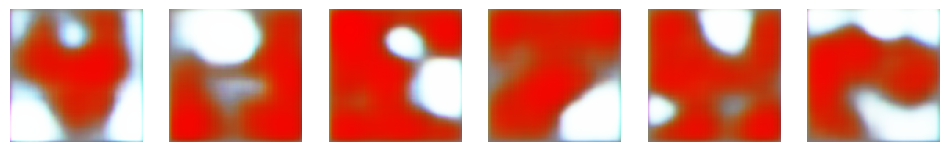

313/313 [==============================] - 92s 242ms/step - g_loss: 3.8915 - d_loss: 0.7401 - real_acc: 0.8271 - gen_acc: 0.9552
Epoch 2/500
313/313 [==============================] - 75s 239ms/step - g_loss: 3.4595 - d_loss: 0.6634 - real_acc: 0.8225 - gen_acc: 0.9770
Epoch 3/500
313/313 [==============================] - 77s 246ms/step - g_loss: 3.8547 - d_loss: 0.5802 - real_acc: 0.8546 - gen_acc: 0.9896
Epoch 4/500
313/313 [==============================] - 77s 247ms/step - g_loss: 4.3344 - d_loss: 0.5501 - real_acc: 0.8734 - gen_acc: 0.9928
Epoch 5/500
313/313 [==============================] - 78s 249ms/step - g_loss: 3.9314 - d_loss: 0.5406 - real_acc: 0.8780 - gen_acc: 0.9955
Epoch 6/500
313/313 [==============================] - 81s 259ms/step - g_loss: 4.3634 - d_loss: 0.5151 - real_acc: 0.8966 - gen_acc: 0.9963
Epoch 7/500
313/313 [==============================] - 83s 264ms/step - g_loss: 4.5526 - d_loss: 0.4670 - real_acc: 0.9224 - gen_acc: 0.9986
Epoch 8/500
313/313 [====

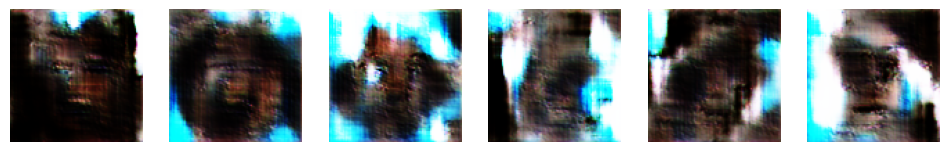

313/313 [==============================] - 86s 275ms/step - g_loss: 5.4834 - d_loss: 0.4417 - real_acc: 0.9343 - gen_acc: 0.9988
Epoch 12/500
313/313 [==============================] - 87s 277ms/step - g_loss: 5.3390 - d_loss: 0.4100 - real_acc: 0.9527 - gen_acc: 0.9994
Epoch 13/500
313/313 [==============================] - 86s 276ms/step - g_loss: 4.8242 - d_loss: 0.4168 - real_acc: 0.9500 - gen_acc: 0.9997
Epoch 14/500
313/313 [==============================] - 87s 278ms/step - g_loss: 5.2533 - d_loss: 0.4033 - real_acc: 0.9552 - gen_acc: 0.9999
Epoch 15/500
313/313 [==============================] - 87s 277ms/step - g_loss: 5.0006 - d_loss: 0.4149 - real_acc: 0.9481 - gen_acc: 1.0000
Epoch 16/500
313/313 [==============================] - 88s 280ms/step - g_loss: 4.7520 - d_loss: 0.4190 - real_acc: 0.9445 - gen_acc: 1.0000
Epoch 17/500
313/313 [==============================] - 87s 278ms/step - g_loss: 4.6113 - d_loss: 0.4338 - real_acc: 0.9345 - gen_acc: 0.9995
Epoch 18/500
313/31

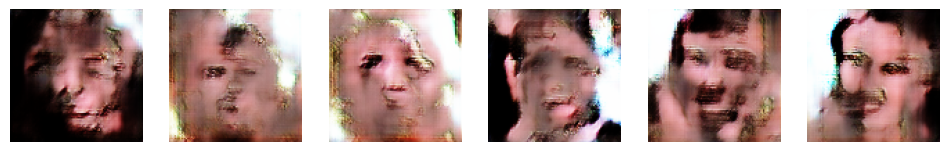

313/313 [==============================] - 87s 279ms/step - g_loss: 4.9229 - d_loss: 0.4202 - real_acc: 0.9490 - gen_acc: 0.9997
Epoch 22/500
313/313 [==============================] - 87s 279ms/step - g_loss: 4.7427 - d_loss: 0.4238 - real_acc: 0.9394 - gen_acc: 0.9999
Epoch 23/500
313/313 [==============================] - 88s 280ms/step - g_loss: 4.8301 - d_loss: 0.4238 - real_acc: 0.9419 - gen_acc: 1.0000
Epoch 24/500
313/313 [==============================] - 87s 279ms/step - g_loss: 4.5968 - d_loss: 0.4328 - real_acc: 0.9318 - gen_acc: 0.9997
Epoch 25/500
313/313 [==============================] - 88s 280ms/step - g_loss: 4.6261 - d_loss: 0.4305 - real_acc: 0.9362 - gen_acc: 0.9994
Epoch 26/500
313/313 [==============================] - 88s 281ms/step - g_loss: 4.5224 - d_loss: 0.4361 - real_acc: 0.9336 - gen_acc: 0.9994
Epoch 27/500
313/313 [==============================] - 88s 281ms/step - g_loss: 4.6100 - d_loss: 0.4273 - real_acc: 0.9373 - gen_acc: 0.9997
Epoch 28/500
313/31

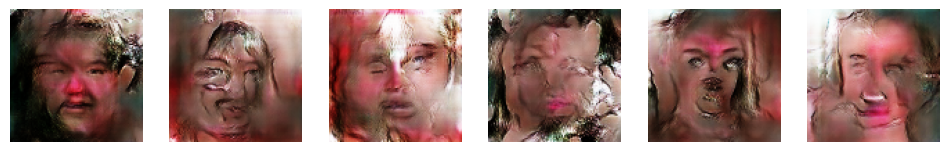

313/313 [==============================] - 88s 281ms/step - g_loss: 4.6202 - d_loss: 0.4237 - real_acc: 0.9397 - gen_acc: 0.9996
Epoch 32/500
313/313 [==============================] - 88s 282ms/step - g_loss: 4.6943 - d_loss: 0.4257 - real_acc: 0.9388 - gen_acc: 0.9998
Epoch 33/500
313/313 [==============================] - 88s 280ms/step - g_loss: 4.6141 - d_loss: 0.4243 - real_acc: 0.9385 - gen_acc: 0.9998
Epoch 34/500
313/313 [==============================] - 88s 282ms/step - g_loss: 4.7931 - d_loss: 0.4225 - real_acc: 0.9434 - gen_acc: 0.9998
Epoch 35/500
313/313 [==============================] - 88s 281ms/step - g_loss: 4.5866 - d_loss: 0.4260 - real_acc: 0.9376 - gen_acc: 0.9993
Epoch 36/500
313/313 [==============================] - 88s 281ms/step - g_loss: 4.7650 - d_loss: 0.4198 - real_acc: 0.9437 - gen_acc: 0.9996
Epoch 37/500
313/313 [==============================] - 88s 281ms/step - g_loss: 4.7186 - d_loss: 0.4203 - real_acc: 0.9430 - gen_acc: 0.9998
Epoch 38/500
313/31

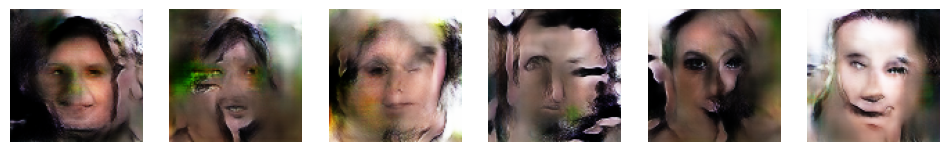

313/313 [==============================] - 88s 283ms/step - g_loss: 4.8056 - d_loss: 0.4176 - real_acc: 0.9455 - gen_acc: 0.9997
Epoch 42/500
313/313 [==============================] - 88s 281ms/step - g_loss: 4.9179 - d_loss: 0.4077 - real_acc: 0.9537 - gen_acc: 0.9999
Epoch 43/500
313/313 [==============================] - 88s 282ms/step - g_loss: 4.9229 - d_loss: 0.4119 - real_acc: 0.9475 - gen_acc: 0.9997
Epoch 44/500
313/313 [==============================] - 88s 282ms/step - g_loss: 4.9296 - d_loss: 0.4126 - real_acc: 0.9488 - gen_acc: 0.9996
Epoch 45/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.0384 - d_loss: 0.4081 - real_acc: 0.9533 - gen_acc: 0.9997
Epoch 46/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.0505 - d_loss: 0.4048 - real_acc: 0.9548 - gen_acc: 0.9998
Epoch 47/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.0984 - d_loss: 0.4038 - real_acc: 0.9564 - gen_acc: 0.9996
Epoch 48/500
313/31

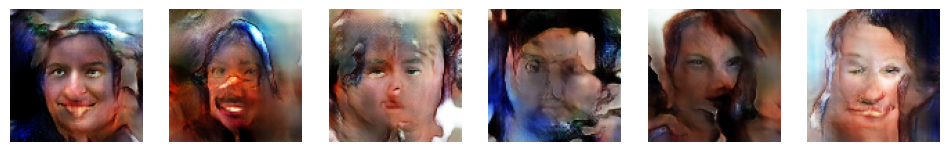

313/313 [==============================] - 89s 283ms/step - g_loss: 5.1609 - d_loss: 0.4058 - real_acc: 0.9534 - gen_acc: 0.9998
Epoch 52/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.1769 - d_loss: 0.4029 - real_acc: 0.9553 - gen_acc: 0.9999
Epoch 53/500
313/313 [==============================] - 88s 283ms/step - g_loss: 5.1448 - d_loss: 0.4049 - real_acc: 0.9552 - gen_acc: 0.9997
Epoch 54/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.1615 - d_loss: 0.4008 - real_acc: 0.9564 - gen_acc: 1.0000
Epoch 55/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.1875 - d_loss: 0.4112 - real_acc: 0.9508 - gen_acc: 0.9995
Epoch 56/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.0928 - d_loss: 0.3986 - real_acc: 0.9579 - gen_acc: 0.9998
Epoch 57/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.2022 - d_loss: 0.3973 - real_acc: 0.9571 - gen_acc: 0.9999
Epoch 58/500
313/31

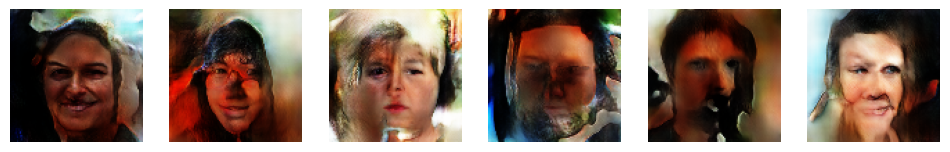

313/313 [==============================] - 89s 284ms/step - g_loss: 5.2257 - d_loss: 0.3983 - real_acc: 0.9593 - gen_acc: 1.0000
Epoch 62/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.1745 - d_loss: 0.4024 - real_acc: 0.9585 - gen_acc: 0.9997
Epoch 63/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.1222 - d_loss: 0.3998 - real_acc: 0.9587 - gen_acc: 0.9998
Epoch 64/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.1246 - d_loss: 0.4090 - real_acc: 0.9527 - gen_acc: 0.9992
Epoch 65/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.1487 - d_loss: 0.4086 - real_acc: 0.9542 - gen_acc: 0.9992
Epoch 66/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.1798 - d_loss: 0.4016 - real_acc: 0.9562 - gen_acc: 0.9997
Epoch 67/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.1960 - d_loss: 0.4010 - real_acc: 0.9591 - gen_acc: 0.9994
Epoch 68/500
313/31

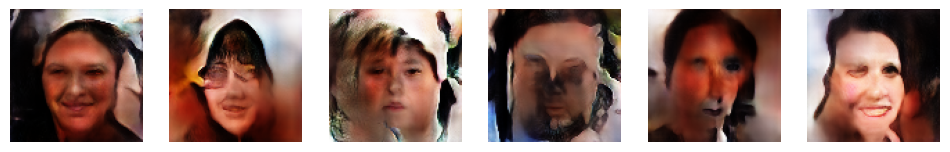

313/313 [==============================] - 89s 286ms/step - g_loss: 5.2084 - d_loss: 0.3970 - real_acc: 0.9600 - gen_acc: 0.9996
Epoch 72/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.2149 - d_loss: 0.4032 - real_acc: 0.9577 - gen_acc: 0.9996
Epoch 73/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.1133 - d_loss: 0.4041 - real_acc: 0.9562 - gen_acc: 0.9998
Epoch 74/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.2056 - d_loss: 0.3947 - real_acc: 0.9620 - gen_acc: 1.0000
Epoch 75/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.2133 - d_loss: 0.3955 - real_acc: 0.9614 - gen_acc: 0.9998
Epoch 76/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.1618 - d_loss: 0.3989 - real_acc: 0.9583 - gen_acc: 0.9998
Epoch 77/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.2768 - d_loss: 0.3952 - real_acc: 0.9609 - gen_acc: 0.9996
Epoch 78/500
313/31

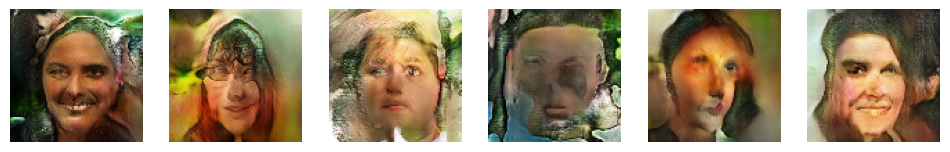

313/313 [==============================] - 89s 285ms/step - g_loss: 5.2757 - d_loss: 0.3906 - real_acc: 0.9659 - gen_acc: 0.9997
Epoch 82/500
313/313 [==============================] - 90s 286ms/step - g_loss: 5.3075 - d_loss: 0.3947 - real_acc: 0.9625 - gen_acc: 0.9997
Epoch 83/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.2542 - d_loss: 0.3918 - real_acc: 0.9628 - gen_acc: 0.9998
Epoch 84/500
313/313 [==============================] - 89s 286ms/step - g_loss: 5.3027 - d_loss: 0.3934 - real_acc: 0.9648 - gen_acc: 0.9999
Epoch 85/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.2927 - d_loss: 0.3900 - real_acc: 0.9652 - gen_acc: 0.9998
Epoch 86/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.3126 - d_loss: 0.3897 - real_acc: 0.9671 - gen_acc: 1.0000
Epoch 87/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.2985 - d_loss: 0.3905 - real_acc: 0.9654 - gen_acc: 1.0000
Epoch 88/500
313/31

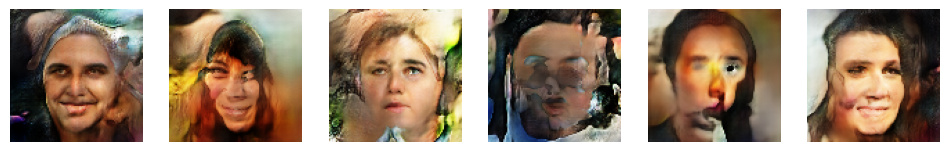

313/313 [==============================] - 89s 285ms/step - g_loss: 5.2448 - d_loss: 0.3917 - real_acc: 0.9635 - gen_acc: 1.0000
Epoch 92/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.3057 - d_loss: 0.3881 - real_acc: 0.9666 - gen_acc: 0.9998
Epoch 93/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.2748 - d_loss: 0.3857 - real_acc: 0.9684 - gen_acc: 1.0000
Epoch 94/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.3583 - d_loss: 0.3879 - real_acc: 0.9670 - gen_acc: 0.9999
Epoch 95/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.3817 - d_loss: 0.3843 - real_acc: 0.9696 - gen_acc: 1.0000
Epoch 96/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.3442 - d_loss: 0.3836 - real_acc: 0.9713 - gen_acc: 0.9999
Epoch 97/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.3463 - d_loss: 0.3853 - real_acc: 0.9688 - gen_acc: 0.9999
Epoch 98/500
313/31

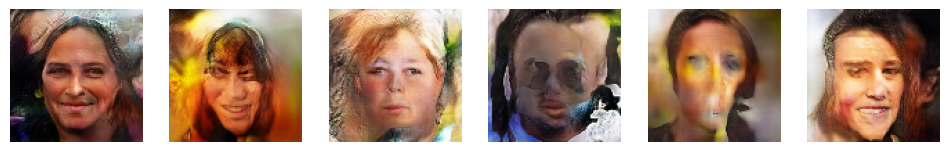

313/313 [==============================] - 89s 285ms/step - g_loss: 5.3196 - d_loss: 0.3902 - real_acc: 0.9672 - gen_acc: 0.9994
Epoch 102/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.3182 - d_loss: 0.3841 - real_acc: 0.9717 - gen_acc: 0.9999
Epoch 103/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.3266 - d_loss: 0.3868 - real_acc: 0.9678 - gen_acc: 1.0000
Epoch 104/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.3147 - d_loss: 0.3855 - real_acc: 0.9701 - gen_acc: 0.9999
Epoch 105/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.3461 - d_loss: 0.3809 - real_acc: 0.9704 - gen_acc: 1.0000
Epoch 106/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.3663 - d_loss: 0.3809 - real_acc: 0.9725 - gen_acc: 0.9998
Epoch 107/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.3841 - d_loss: 0.3825 - real_acc: 0.9721 - gen_acc: 0.9998
Epoch 108/500

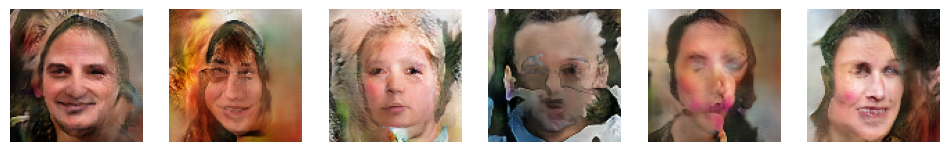

313/313 [==============================] - 89s 283ms/step - g_loss: 5.4087 - d_loss: 0.3863 - real_acc: 0.9696 - gen_acc: 0.9999
Epoch 112/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.3475 - d_loss: 0.3825 - real_acc: 0.9699 - gen_acc: 0.9999
Epoch 113/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.3974 - d_loss: 0.3783 - real_acc: 0.9732 - gen_acc: 0.9999
Epoch 114/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.3571 - d_loss: 0.3761 - real_acc: 0.9737 - gen_acc: 1.0000
Epoch 115/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.4598 - d_loss: 0.3753 - real_acc: 0.9749 - gen_acc: 1.0000
Epoch 116/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.4505 - d_loss: 0.3759 - real_acc: 0.9766 - gen_acc: 1.0000
Epoch 117/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.3691 - d_loss: 0.3804 - real_acc: 0.9727 - gen_acc: 1.0000
Epoch 118/500

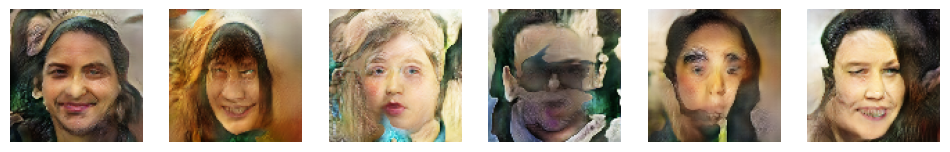

313/313 [==============================] - 89s 284ms/step - g_loss: 5.4105 - d_loss: 0.3763 - real_acc: 0.9747 - gen_acc: 0.9999
Epoch 122/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.4332 - d_loss: 0.3765 - real_acc: 0.9748 - gen_acc: 1.0000
Epoch 123/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.4203 - d_loss: 0.3752 - real_acc: 0.9763 - gen_acc: 1.0000
Epoch 124/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.4917 - d_loss: 0.3753 - real_acc: 0.9759 - gen_acc: 0.9999
Epoch 125/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.4163 - d_loss: 0.3838 - real_acc: 0.9703 - gen_acc: 0.9999
Epoch 126/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.3827 - d_loss: 0.3774 - real_acc: 0.9752 - gen_acc: 1.0000
Epoch 127/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.4111 - d_loss: 0.3750 - real_acc: 0.9761 - gen_acc: 0.9999
Epoch 128/500

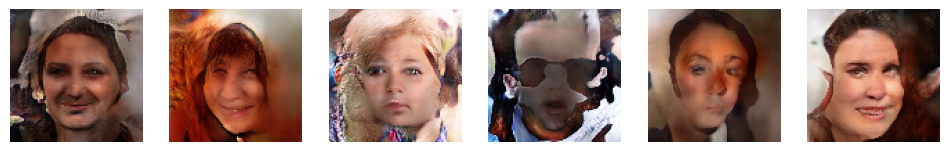

313/313 [==============================] - 89s 284ms/step - g_loss: 5.4998 - d_loss: 0.3753 - real_acc: 0.9760 - gen_acc: 1.0000
Epoch 132/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.4936 - d_loss: 0.3780 - real_acc: 0.9747 - gen_acc: 1.0000
Epoch 133/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.4102 - d_loss: 0.3772 - real_acc: 0.9757 - gen_acc: 0.9999
Epoch 134/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.4865 - d_loss: 0.3763 - real_acc: 0.9749 - gen_acc: 0.9999
Epoch 135/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.4329 - d_loss: 0.3761 - real_acc: 0.9765 - gen_acc: 1.0000
Epoch 136/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.4554 - d_loss: 0.3739 - real_acc: 0.9771 - gen_acc: 1.0000
Epoch 137/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.4588 - d_loss: 0.3749 - real_acc: 0.9766 - gen_acc: 0.9999
Epoch 138/500

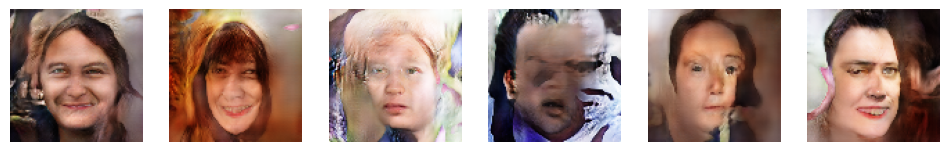

313/313 [==============================] - 89s 284ms/step - g_loss: 5.4966 - d_loss: 0.3736 - real_acc: 0.9776 - gen_acc: 1.0000
Epoch 142/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.4999 - d_loss: 0.3726 - real_acc: 0.9795 - gen_acc: 0.9999
Epoch 143/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.4754 - d_loss: 0.3744 - real_acc: 0.9762 - gen_acc: 0.9999
Epoch 144/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.4554 - d_loss: 0.3723 - real_acc: 0.9782 - gen_acc: 1.0000
Epoch 145/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.4845 - d_loss: 0.3733 - real_acc: 0.9764 - gen_acc: 1.0000
Epoch 146/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.5326 - d_loss: 0.3732 - real_acc: 0.9768 - gen_acc: 1.0000
Epoch 147/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.5743 - d_loss: 0.3678 - real_acc: 0.9812 - gen_acc: 0.9999
Epoch 148/500

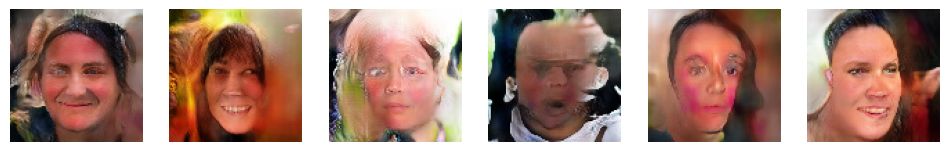

313/313 [==============================] - 89s 283ms/step - g_loss: 5.5205 - d_loss: 0.3694 - real_acc: 0.9799 - gen_acc: 1.0000
Epoch 152/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.4747 - d_loss: 0.3778 - real_acc: 0.9759 - gen_acc: 0.9999
Epoch 153/500
313/313 [==============================] - 89s 285ms/step - g_loss: 5.4294 - d_loss: 0.3782 - real_acc: 0.9732 - gen_acc: 1.0000
Epoch 154/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.4781 - d_loss: 0.3716 - real_acc: 0.9780 - gen_acc: 1.0000
Epoch 155/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.5336 - d_loss: 0.3688 - real_acc: 0.9821 - gen_acc: 1.0000
Epoch 156/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.5776 - d_loss: 0.3657 - real_acc: 0.9820 - gen_acc: 1.0000
Epoch 157/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.5695 - d_loss: 0.3712 - real_acc: 0.9799 - gen_acc: 0.9997
Epoch 158/500

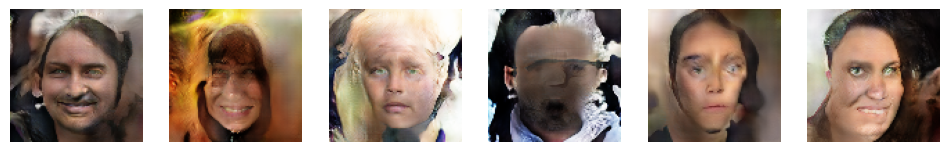

313/313 [==============================] - 89s 284ms/step - g_loss: 5.5587 - d_loss: 0.3723 - real_acc: 0.9786 - gen_acc: 0.9999
Epoch 162/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.5475 - d_loss: 0.3681 - real_acc: 0.9799 - gen_acc: 0.9999
Epoch 163/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.5516 - d_loss: 0.3662 - real_acc: 0.9829 - gen_acc: 1.0000
Epoch 164/500
313/313 [==============================] - 88s 283ms/step - g_loss: 5.7045 - d_loss: 0.3653 - real_acc: 0.9818 - gen_acc: 1.0000
Epoch 165/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.5713 - d_loss: 0.3688 - real_acc: 0.9802 - gen_acc: 1.0000
Epoch 166/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.4989 - d_loss: 0.3694 - real_acc: 0.9808 - gen_acc: 1.0000
Epoch 167/500
313/313 [==============================] - 88s 283ms/step - g_loss: 5.5773 - d_loss: 0.3661 - real_acc: 0.9829 - gen_acc: 1.0000
Epoch 168/500

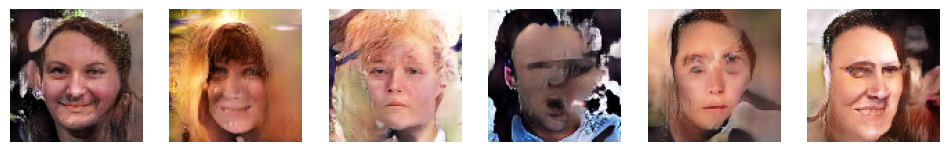

313/313 [==============================] - 89s 284ms/step - g_loss: 5.6258 - d_loss: 0.3643 - real_acc: 0.9840 - gen_acc: 1.0000
Epoch 172/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.6588 - d_loss: 0.3628 - real_acc: 0.9839 - gen_acc: 0.9999
Epoch 173/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.6213 - d_loss: 0.3643 - real_acc: 0.9836 - gen_acc: 1.0000
Epoch 174/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.6626 - d_loss: 0.3642 - real_acc: 0.9848 - gen_acc: 1.0000
Epoch 175/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.6394 - d_loss: 0.3650 - real_acc: 0.9829 - gen_acc: 1.0000
Epoch 176/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.6417 - d_loss: 0.3639 - real_acc: 0.9841 - gen_acc: 0.9999
Epoch 177/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.5993 - d_loss: 0.3645 - real_acc: 0.9839 - gen_acc: 1.0000
Epoch 178/500

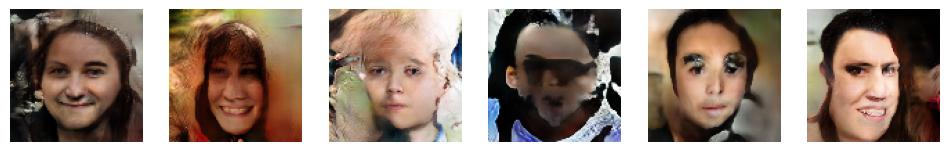

313/313 [==============================] - 89s 284ms/step - g_loss: 5.6496 - d_loss: 0.3635 - real_acc: 0.9844 - gen_acc: 1.0000
Epoch 182/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.6255 - d_loss: 0.3634 - real_acc: 0.9853 - gen_acc: 1.0000
Epoch 183/500
313/313 [==============================] - 88s 283ms/step - g_loss: 5.6494 - d_loss: 0.3612 - real_acc: 0.9868 - gen_acc: 1.0000
Epoch 184/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.6856 - d_loss: 0.3637 - real_acc: 0.9858 - gen_acc: 1.0000
Epoch 185/500
313/313 [==============================] - 88s 281ms/step - g_loss: 5.6262 - d_loss: 0.3659 - real_acc: 0.9829 - gen_acc: 1.0000
Epoch 186/500
313/313 [==============================] - 88s 281ms/step - g_loss: 5.6463 - d_loss: 0.3643 - real_acc: 0.9834 - gen_acc: 0.9999
Epoch 187/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.6765 - d_loss: 0.3633 - real_acc: 0.9857 - gen_acc: 0.9999
Epoch 188/500

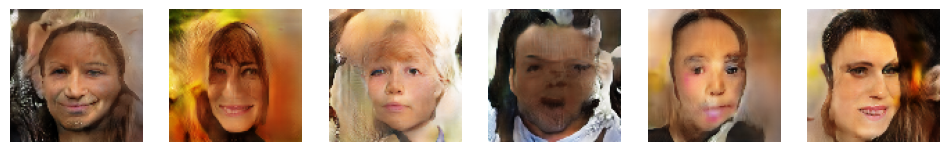

313/313 [==============================] - 89s 283ms/step - g_loss: 5.7281 - d_loss: 0.3600 - real_acc: 0.9873 - gen_acc: 1.0000
Epoch 192/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.7044 - d_loss: 0.3630 - real_acc: 0.9856 - gen_acc: 1.0000
Epoch 193/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.6768 - d_loss: 0.3630 - real_acc: 0.9844 - gen_acc: 1.0000
Epoch 194/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.6474 - d_loss: 0.3638 - real_acc: 0.9857 - gen_acc: 1.0000
Epoch 195/500
313/313 [==============================] - 88s 283ms/step - g_loss: 5.6913 - d_loss: 0.3608 - real_acc: 0.9855 - gen_acc: 1.0000
Epoch 196/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.7698 - d_loss: 0.3602 - real_acc: 0.9867 - gen_acc: 1.0000
Epoch 197/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.6993 - d_loss: 0.3618 - real_acc: 0.9865 - gen_acc: 1.0000
Epoch 198/500

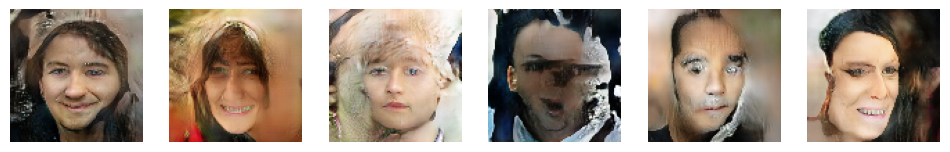

313/313 [==============================] - 89s 283ms/step - g_loss: 5.6702 - d_loss: 0.3620 - real_acc: 0.9841 - gen_acc: 1.0000
Epoch 202/500
313/313 [==============================] - 88s 283ms/step - g_loss: 5.6479 - d_loss: 0.3653 - real_acc: 0.9836 - gen_acc: 1.0000
Epoch 203/500
313/313 [==============================] - 88s 283ms/step - g_loss: 5.6649 - d_loss: 0.3619 - real_acc: 0.9869 - gen_acc: 1.0000
Epoch 204/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.7530 - d_loss: 0.3601 - real_acc: 0.9881 - gen_acc: 1.0000
Epoch 205/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.7630 - d_loss: 0.3596 - real_acc: 0.9860 - gen_acc: 1.0000
Epoch 206/500
313/313 [==============================] - 88s 283ms/step - g_loss: 5.7037 - d_loss: 0.3619 - real_acc: 0.9853 - gen_acc: 0.9999
Epoch 207/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.7272 - d_loss: 0.3614 - real_acc: 0.9865 - gen_acc: 1.0000
Epoch 208/500

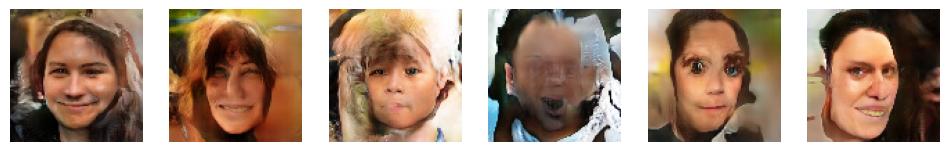

313/313 [==============================] - 89s 284ms/step - g_loss: 5.7696 - d_loss: 0.3584 - real_acc: 0.9880 - gen_acc: 0.9999
Epoch 212/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.7227 - d_loss: 0.3591 - real_acc: 0.9858 - gen_acc: 1.0000
Epoch 213/500
313/313 [==============================] - 89s 284ms/step - g_loss: 5.7474 - d_loss: 0.3601 - real_acc: 0.9866 - gen_acc: 1.0000
Epoch 214/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.7566 - d_loss: 0.3597 - real_acc: 0.9867 - gen_acc: 1.0000
Epoch 215/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.8004 - d_loss: 0.3569 - real_acc: 0.9887 - gen_acc: 1.0000
Epoch 216/500
313/313 [==============================] - 88s 282ms/step - g_loss: 5.7664 - d_loss: 0.3591 - real_acc: 0.9892 - gen_acc: 1.0000
Epoch 217/500
313/313 [==============================] - 89s 283ms/step - g_loss: 5.7478 - d_loss: 0.3616 - real_acc: 0.9870 - gen_acc: 1.0000
Epoch 218/500

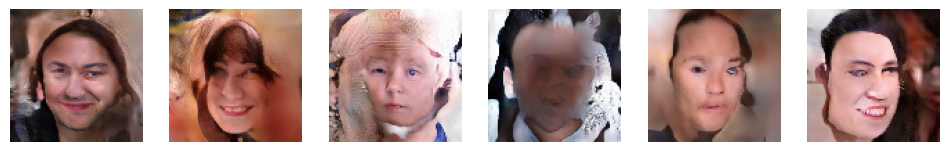

313/313 [==============================] - 90s 286ms/step - g_loss: 5.7739 - d_loss: 0.3560 - real_acc: 0.9892 - gen_acc: 1.0000
Epoch 222/500
  1/313 [..............................] - ETA: 1:24 - g_loss: 4.8333 - d_loss: 0.3515 - real_acc: 1.0000 - gen_acc: 1.0000

In [14]:
history = gan.fit(train_dataset,
        epochs=500,
        callbacks=[ImageProgress(LATENT_DIM)]) 

In [24]:
history = gan.history

In [26]:
g_loss, d_loss = history.history.values()

In [28]:
generator.save_weights("generator_msg.weights.h5")
discriminator.save_weights("discriminator_msg.weights.h5")

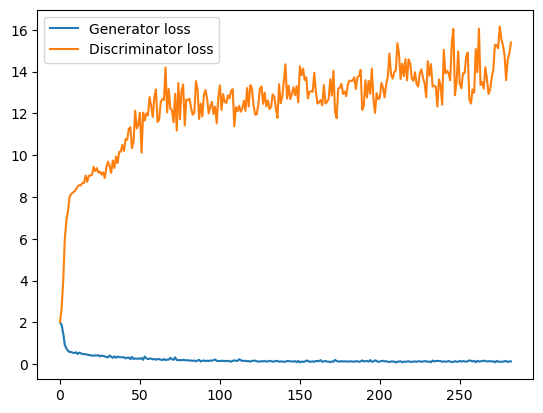

In [29]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.legend(['Generator loss','Discriminator loss'])
plt.show()

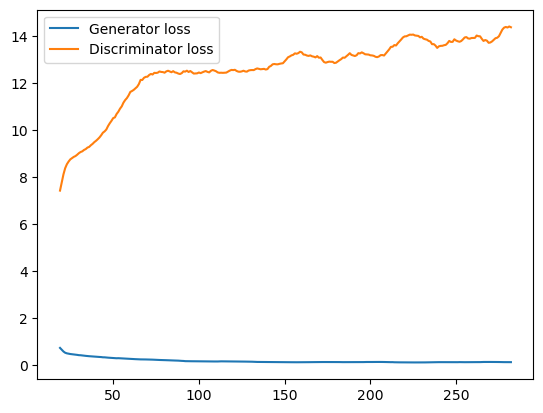

In [30]:
# Lets take a look at the smoothed plot (Simple Moving Average)

window_size = 20
# Convert array of integers to pandas series
d_sma_loss = pd.Series(d_loss)
g_sma_loss = pd.Series(g_loss)
  
# Get the window of series of observations of the specified window size
d_sma_loss = d_sma_loss.rolling(window_size).mean()
g_sma_loss = g_sma_loss.rolling(window_size).mean()

# Convert pandas series back to list
d_sma_loss = d_sma_loss.tolist()
g_sma_loss = g_sma_loss.tolist()

plt.plot(g_sma_loss)
plt.plot(d_sma_loss)
plt.legend(['Generator loss','Discriminator loss'])
plt.show()

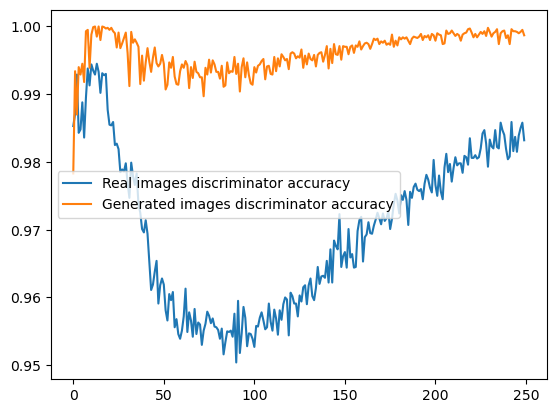

In [37]:
plt.plot(real_acc)
plt.plot(fake_acc)
plt.legend(['Real images discriminator accuracy','Generated images discriminator accuracy'])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

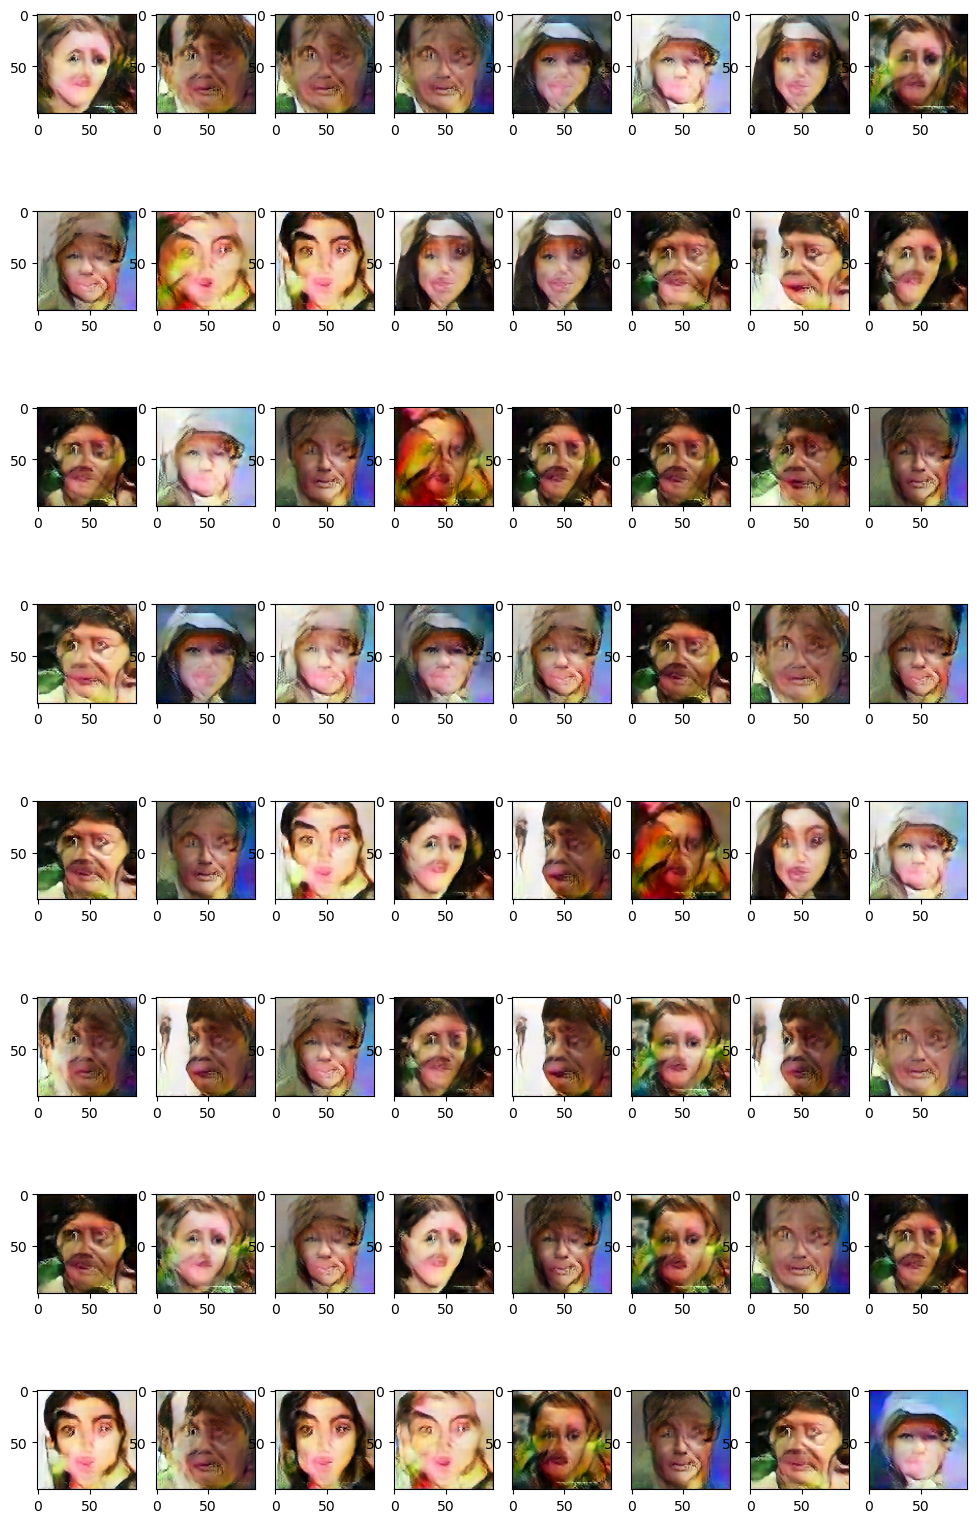

In [32]:
noise = tf.random.normal((64,LATENT_DIM))
generated = generator(noise,training=False)[-1]
fig = plt.figure(figsize=(12,20))
for i in range(8):
  for j in range(8):
    fig.add_subplot(8,8,i*8+j+1)
    plt.imshow((generated[i*8+j]+1)*0.5)
plt.show()

In [35]:
# 1. averaging two vectors
examples = 6
noise_1 = np.random.normal(size=(examples,LATENT_DIM))
noise_2 = np.random.normal(size=(examples,LATENT_DIM))
merged = (noise_1 + noise_2)/2 #mean

imgs_1 = generator(noise_1,training=False)[-1]
imgs_2 = generator(noise_2,training=False)[-1]
result = generator(merged,training=False)[-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

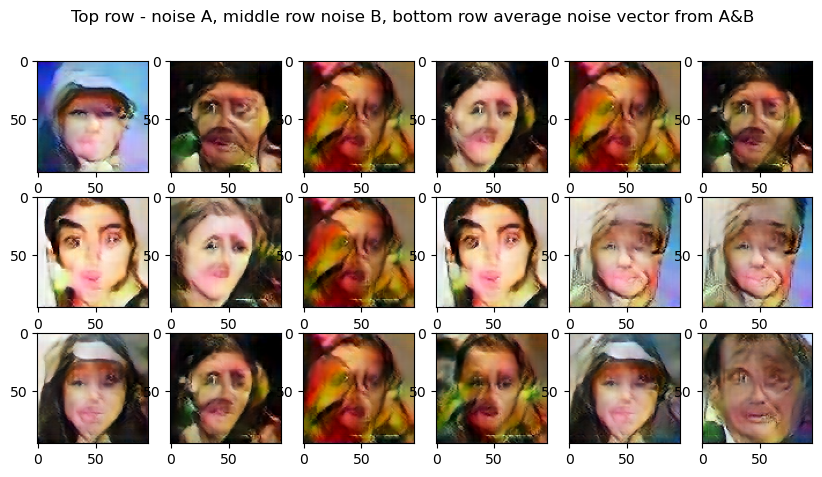

In [36]:
fig = plt.figure(figsize=(10,5))
for i, (a,b,c) in enumerate(zip(imgs_1,imgs_2,result)):
    fig.add_subplot(3,examples,1+i)
    plt.imshow((a+1)*0.5)
    fig.add_subplot(3,examples,examples+i+1)
    plt.imshow((b+1)*0.5)
    fig.add_subplot(3,examples,2*examples+i+1)
    plt.imshow((c+1)*0.5)

fig.suptitle("Top row - noise A, middle row noise B, bottom row average noise vector from A&B")
plt.show()

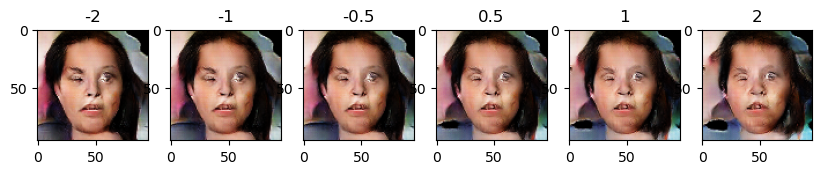

In [42]:
# Feature manipulation (changing single value in the original noise vector) 
noise = np.random.normal(size=(1,LATENT_DIM))
vals = [-2,-1,-0.5,0.5,1,2]                  # values to check
feature = 55                                 # from [0,LATENT_DIM-1]

def plot_feature_change(values,feature,noise):
    fig = plt.figure(figsize=(10,4))
    for index, shift in enumerate(values):
        noise_changed = np.copy(noise)
        noise_changed[0,feature] += shift
        image = generator(noise_changed)
        fig.add_subplot(1,len(vals),1+index)
        plt.imshow((image[0]+1)/2)
        plt.title(shift)
    plt.show()

plot_feature_change(vals,feature,noise)

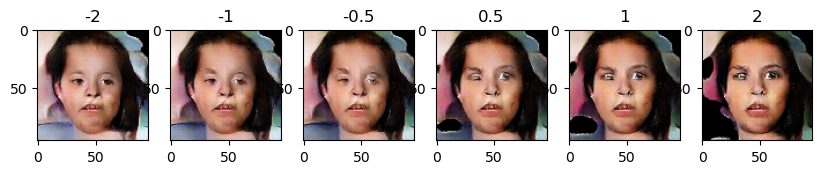

In [43]:
plot_feature_change(vals,11,noise)

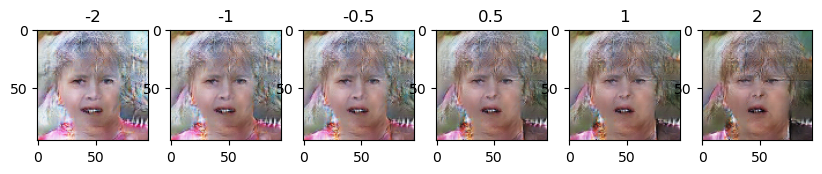

In [44]:
noise = np.random.normal(size=(1,LATENT_DIM)) #new noise
plot_feature_change(vals,11,noise)